In [1]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
path_cats_and_dogs = f"{getcwd()}/dogsandcats.zip"

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [22]:
print(len(os.listdir('/tmp/dogsandcats/cats/')))
print(len(os.listdir('/tmp/dogsandcats/dogs/')))

12500
12501


In [11]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [38]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length")
    training_length = int(len(files)*SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
    
    for filename in training_set:
        this_file = SOURCE +filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
        
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
        
CAT_SOURCE_DIR = '/tmp/dogsandcats/cats/'
DOG_SOURCE_DIR = '/tmp/dogsandcats/dogs/'
TRAINING_CATS_DIR = '/tmp/cats-v-dogs/training/cats/'
TRAINING_DOGS_DIR = '/tmp/cats-v-dogs/training/dogs/'
TESTING_CATS_DIR = '/tmp/cats-v-dogs/testing/cats/'
TESTING_DOGS_DIR = '/tmp/cats-v-dogs/testing/dogs/'

split_size = 0.8
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [32]:
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))

12478
12500
4436
7213


In [33]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [37]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.)

TESTING_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size = 100,
                                                   class_mode = 'binary',
                                                   target_size =(150,150))

validation_generator = validation_datagen.flow_from_directory(TESTING_DIR,
                                                   batch_size = 100,
                                                   class_mode = 'binary',
                                                   target_size =(150,150))

Found 24977 images belonging to 2 classes.
Found 11648 images belonging to 2 classes.


In [39]:
model.compile(optimizer=RMSprop(lr=0.001), loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [40]:
history = model.fit_generator(train_generator,
                             validation_data=validation_generator,
                             epochs = 5, #Try with 9-10 epochs for good accuracy
                             verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 250 steps, validate for 117 steps
Epoch 1/5
250/250 [==============================] - 247s 989ms/step - loss: 0.7161 - accuracy: 0.6288 - val_loss: 0.6748 - val_accuracy: 0.5781
Epoch 2/5
250/250 [==============================] - 249s 997ms/step - loss: 0.5146 - accuracy: 0.7469 - val_loss: 0.4378 - val_accuracy: 0.8105
Epoch 3/5
250/250 [==============================] - 285s 1s/step - loss: 0.4347 - accuracy: 0.7969 - val_loss: 0.3504 - val_accuracy: 0.8419
Epoch 4/5
250/250 [==============================] - 269s 1s/step - loss: 0.3711 - accuracy: 0.8338 - val_loss: 0.3045 - val_accuracy: 0.8744
Epoch 5/5
250/250 [==============================] - 245s 981ms/step - loss: 0.3073 - accuracy: 0.8668 - val_loss: 0.2116 - val_accuracy: 0.9220


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Training and validation loss')

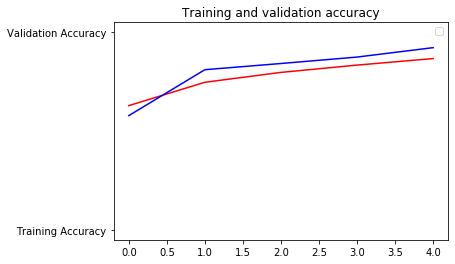

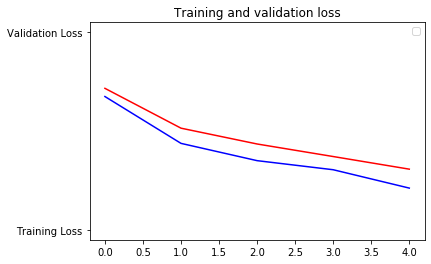

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend()

plt.title('Training and validation loss')